In [ ]:
#%% Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, 
    roc_curve, auc, confusion_matrix, classification_report
)
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#%% Load and preprocess the dataset
df = pd.read_csv("../data/cumulative.csv")

df.dropna(axis=1, how="all", inplace=True)
df.fillna(df.mean(numeric_only=True), inplace=True)

if 'koi_disposition' in df.columns:
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df['koi_disposition'])  # Target variable
else:
    raise ValueError("Dataset must contain 'koi_disposition' column for supervised learning.")

numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numerical_features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
#%% Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
#%% Define function to train and evaluate models (for parametric transformations)
def train_and_evaluate(X_train_reduced, X_test_reduced, title, model_type="RandomForest"):
    if model_type == "RandomForest":
        clf = RandomForestClassifier()
    else:
        clf = KNeighborsClassifier(n_neighbors=5)
    
    clf.fit(X_train_reduced, y_train)
    y_pred = clf.predict(X_test_reduced)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print(f"\n{title} Model Performance:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Confusion Matrix
    plt.figure(figsize=(6, 4))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{title} Confusion Matrix")
    plt.show()
    
    # ROC Curve (if applicable for binary classification)
    if len(np.unique(y_test)) == 2:
        y_prob = clf.predict_proba(X_test_reduced)
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, 1], pos_label=1)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{title} (AUC = {roc_auc:.2f})")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(loc="lower right")
        plt.title(f"{title} ROC Curve")
        plt.show()

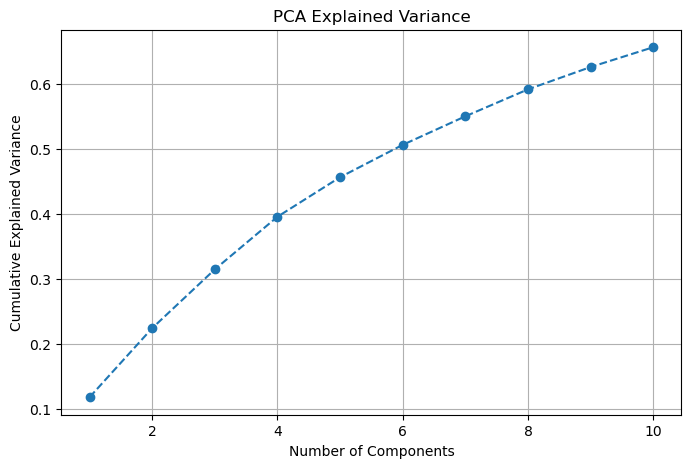


PCA Model Performance:
Accuracy: 0.8359
Precision: 0.8280
Recall: 0.8359
F1-Score: 0.8284

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.72      0.55      0.62       449
     CONFIRMED       0.75      0.81      0.78       459
FALSE POSITIVE       0.91      0.98      0.94      1005

      accuracy                           0.84      1913
     macro avg       0.79      0.78      0.78      1913
  weighted avg       0.83      0.84      0.83      1913



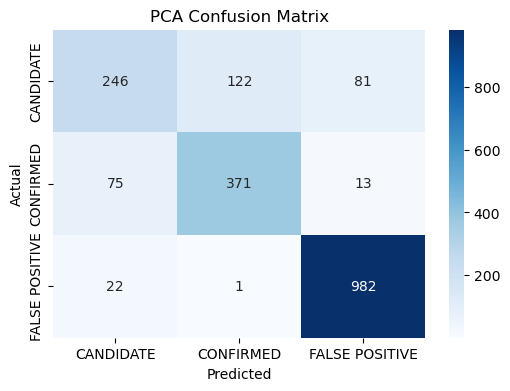

In [ ]:
#%% Apply PCA
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Explained Variance Plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), np.cumsum(pca.explained_variance_ratio_), marker="o", linestyle="--")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.grid()
plt.show()

train_and_evaluate(X_train_pca, X_test_pca, "PCA")


LDA Model Performance:
Accuracy: 0.8641
Precision: 0.8640
Recall: 0.8641
F1-Score: 0.8640

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.73      0.73      0.73       449
     CONFIRMED       0.75      0.75      0.75       459
FALSE POSITIVE       0.98      0.98      0.98      1005

      accuracy                           0.86      1913
     macro avg       0.82      0.82      0.82      1913
  weighted avg       0.86      0.86      0.86      1913



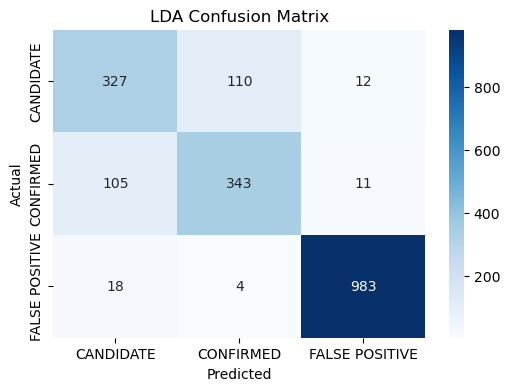

In [ ]:
#%% Apply LDA
lda = LDA(n_components=2)
X_train_lda = lda.fit_transform(X_train, y_train)
X_test_lda = lda.transform(X_test)
train_and_evaluate(X_train_lda, X_test_lda, "LDA")


t-SNE Model Performance:
Accuracy: 0.5917
Precision: 0.6324
Recall: 0.5917
F1-Score: 0.6061

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.28      0.40      0.32       449
     CONFIRMED       0.57      0.42      0.48       459
FALSE POSITIVE       0.82      0.76      0.79      1005

      accuracy                           0.59      1913
     macro avg       0.56      0.52      0.53      1913
  weighted avg       0.63      0.59      0.61      1913



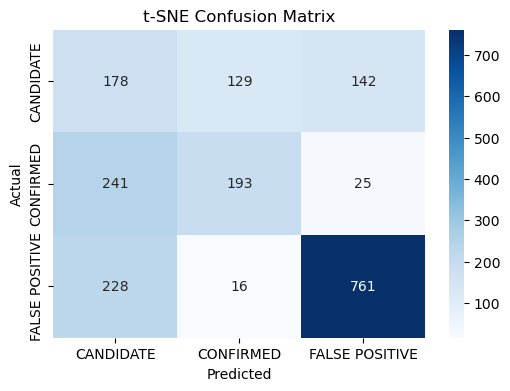

In [ ]:
#%% Apply t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200)
X_train_tsne = tsne.fit_transform(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_tsne[:,0], y=X_train_tsne[:,1], hue=y_train, palette="viridis")
plt.title("t-SNE Visualization on Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()


MDS Model Performance:
Accuracy: 0.6571
Precision: 0.6492
Recall: 0.6571
F1-Score: 0.6519

Classification Report:
                precision    recall  f1-score   support

     CANDIDATE       0.37      0.39      0.38       449
     CONFIRMED       0.52      0.44      0.47       459
FALSE POSITIVE       0.83      0.88      0.85      1005

      accuracy                           0.66      1913
     macro avg       0.57      0.57      0.57      1913
  weighted avg       0.65      0.66      0.65      1913



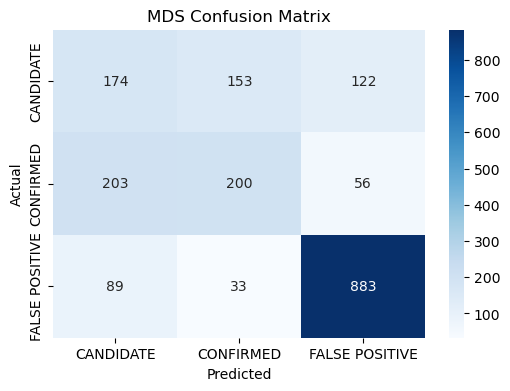

In [9]:
#%% Apply MDS
mds = MDS(n_components=2, random_state=42)
X_train_mds = mds.fit_transform(X_train)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_train_mds[:,0], y=X_train_mds[:,1], hue=y_train, palette="magma")
plt.title("MDS Visualization on Training Data")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

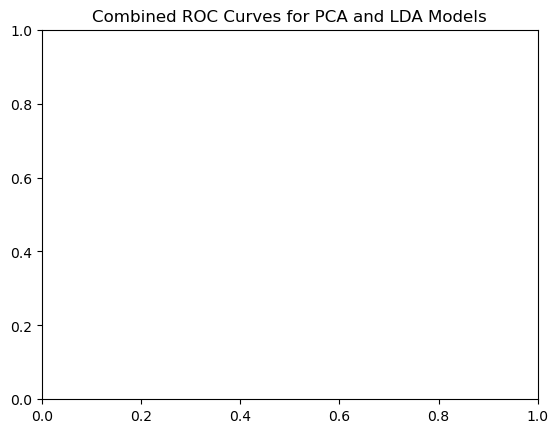


Model Training and Evaluation Completed.


In [10]:
#%% Show combined ROC curves for PCA and LDA models (if applicable)
plt.figure()
plt.title("Combined ROC Curves for PCA and LDA Models")
plt.show()
print("\nModel Training and Evaluation Completed.")